In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
cfgs, btests = [], []
for p in Path("optimization").glob("*.pickle"):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)

opt_summary = {k:[] for k in cfgs[0].keys()}
for k in opt_summary.keys():
    for cfg in cfgs:
        v = cfg[k]
        if type(v) is EasyDict and "func" in v.keys():
            opt_summary[k].append(str(v.func.name))
        else:
            opt_summary[k].append(v)
            
opt_summary["btest"], opt_summary["ndeals"] = [], []
for btest in btests:
    opt_summary["btest"].append(btest.profits.sum())
    opt_summary["ndeals"].append(len(btest.profits))
    
opt_summary = pd.DataFrame(opt_summary)
opt_summary.sort_values(by=["btest"], ascending=False, inplace=True)
opt_summary.head(10)

,body_classifier,stops_processor,wait_entry_point,hist_buffer_size,tstart,tend,period,ticker,data_type,save_plots,btest,ndeals
123,trend:npairs=2,"stops_fix:tp=8,sl=8",9999,30,0,None,H1,TRXUSD,bitfinex,False,296.000000,387
13,trend:npairs=2,"stops_fix:tp=8,sl=8",9999,30,0,None,H1,ETHUSD,bitfinex,False,256.000000,360
140,trend:npairs=2,"stops_fix:tp=4,sl=2",9999,30,0,None,H1,TRXUSD,bitfinex,False,233.563815,927
35,trend:npairs=2,"stops_fix:tp=8,sl=2",9999,30,0,None,H1,TRXUSD,bitfinex,False,228.629163,765
102,trend:npairs=3,"stops_fix:tp=4,sl=2",9999,30,0,None,H1,TRXUSD,bitfinex,False,209.957105,555
65,trend:npairs=2,"stops_fix:tp=4,sl=4",9999,30,0,None,H1,TRXUSD,bitfinex,False,209.010223,726
23,trend:npairs=3,"stops_fix:tp=8,sl=2",9999,30,0,None,H1,BTCUSD,bitfinex,False,204.000000,408
148,trend:npairs=3,"stops_fix:tp=8,sl=2",9999,30,0,None,H1,TRXUSD,bitfinex,False,197.947412,466
63,trend:npairs=3,"stops_fix:tp=8,sl=8",9999,30,0,None,H1,TRXUSD,bitfinex,False,196.875801,301
74,trend:npairs=3,stops_dyn:dummy=0,9999,30,0,None,H1,BTCUSD,bitfinex,False,191.404104,299


In [5]:
opt_res = {"param_set":[], "ticker":[], "btest":[], "ndeals":[], "test_ids":[]}
for i in range(opt_summary.shape[0]):
    exphash, test_ids = "", ""
    for col in opt_summary.columns:
        if col not in ["ticker", "btest", "ndeals"]:
            exphash += str(opt_summary[col].iloc[i]) + " "
    opt_res["test_ids"].append(f".{opt_summary.index[i]}")
    opt_res["param_set"].append(exphash)
    opt_res["ticker"].append(f".{opt_summary.ticker.iloc[i]}")
    opt_res["ndeals"].append(opt_summary.ndeals.iloc[i])
    opt_res["btest"].append(opt_summary.btest.iloc[i])

opt_res = pd.DataFrame(opt_res)
opt_res = opt_res.groupby(by="param_set").sum()
opt_res.sort_values(by=["btest"], ascending=False, inplace=True)
opt_res.head(20)

,ticker,btest,ndeals,test_ids
param_set,,,,
"trend:npairs=2 stops_fix:tp=8,sl=8 9999 30 0 None H1 bitfinex False",.TRXUSD.ETHUSD.XRPUSD.BTCUSD,710.047909,1360,.123.13.50.59
"trend:npairs=2 stops_fix:tp=8,sl=2 9999 30 0 None H1 bitfinex False",.TRXUSD.ETHUSD.BTCUSD.XRPUSD,616.467107,2921,.35.125.62.70
"trend:npairs=2 stops_fix:tp=4,sl=8 9999 30 0 None H1 bitfinex False",.ETHUSD.TRXUSD.XRPUSD.BTCUSD,533.002050,1969,.157.137.60.71
"trend:npairs=3 stops_fix:tp=8,sl=2 9999 30 0 None H1 bitfinex False",.BTCUSD.TRXUSD.XRPUSD.ETHUSD,507.017236,1815,.23.148.91.49
"trend:npairs=3 stops_fix:tp=4,sl=2 9999 30 0 None H1 bitfinex False",.TRXUSD.BTCUSD.XRPUSD.ETHUSD,433.829724,2113,.102.114.82.147
"trend:npairs=2 stops_fix:tp=4,sl=2 9999 30 0 None H1 bitfinex False",.TRXUSD.ETHUSD.XRPUSD.BTCUSD,394.741024,3540,.140.39.24.128
"trend:npairs=3 stops_fix:tp=8,sl=8 9999 30 0 None H1 bitfinex False",.TRXUSD.BTCUSD.XRPUSD.ETHUSD,372.875801,1049,.63.121.41.111
"trend:npairs=2 stops_fix:tp=2,sl=2 9999 30 0 None H1 bitfinex False",.ETHUSD.TRXUSD.XRPUSD.BTCUSD,354.900347,4175,.64.145.22.159
"trend:npairs=2 stops_fix:tp=4,sl=4 9999 30 0 None H1 bitfinex False",.TRXUSD.XRPUSD.ETHUSD.BTCUSD,288.882843,2729,.65.144.16.88


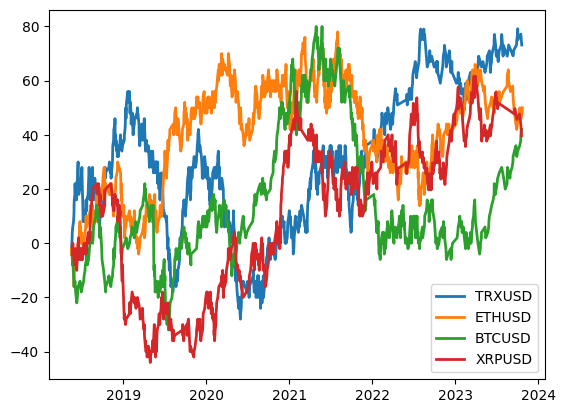

In [14]:
opt_res_id = 9
legend = []
for test_id in map(int, opt_res.test_ids.iloc[opt_res_id].split(".")[1:]):
    plt.plot([pos.close_date for pos in btests[test_id].positions], 
             btests[test_id].profits.cumsum(), 
             linewidth=2)
    legend.append(cfgs[test_id].ticker)
plt.legend(legend)